# Anchored CorEx: Topic Modeling with Minimal Domain Knowledge

**Author:** [Ryan J. Gallagher](http://ryanjgallagher.github.io/)  

**Last updated:** 03/22/2021

This notebook walks through how to use the CorEx topic model code. This includes fitting CorEx to your data, examining the topic model output, outputting results, building a hierarchical topic model, and anchoring words to topics.

Details of the CorEx topic model and evaluations against unsupervised and semi-supervised variants of LDA can be found in our TACL paper:

Gallagher, Ryan J., Kyle Reing, David Kale, and Greg Ver Steeg. "[Anchored Correlation Explanation: Topic Modeling with Minimal Domain Knowledge](https://www.transacl.org/ojs/index.php/tacl/article/view/1244)." *Transactions of the Association for Computational Linguistics (TACL)*, 2017.

In [1]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

import corextopic.corextopic as ct
import corextopic.vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
%matplotlib inline

## Loading the documents data

We need to first load data to run the CorEx topic model. We'll use the 20 Newsgroups dataset, which scikit-learn provides functionality to access.

In [2]:
documents_train = list(np.load('./training/train.npy')) # historical materials 4451 documents
documents_train2 = list(np.load('./training/train2.npy'))   # census bureau 4226 documents
documents_train.extend(documents_train2)
documents=documents_train
documents

['Skip to main content Search UPLOAD SIGN UP | LOG IN BOOKS VIDEO AUDIO SOFTWARE IMAGESABOUT BLOG PROJECTS HELP DONATE  CONTACT JOBS VOLUNTEER PEOPLE Search Metadata Search text contents Search TV news captions Search radio transcripts Search archived websitesAdvanced SearchSign up for freeLog inFull text of "The practical cabinet maker and furniture designer\'s assistant, with essays on history of furniture, taste in design, color and materials, with full explanation of the canons of good taste in furniture .."See other formats^ ',
 'HISTORY OF FURNITURE, TASTE IN DESIGN, COLOR AND MATERIALS, WITH FULL EXPLANATION OF THE CANONS OF GOOD TASTE IN FURNITURE ',
 'Together with Many Practical Directions for Making Cabinet Work Generally, and a Number of Pieces of Furniture in Particular, along with Hundreds of Recipes for Finishing, Staining, Varnishing, Polishing and Gilding all kinds of Cabinet Work :: :: :: ',
 'Author of "Practical Treatise on the Steel Sojmrk," "Modern Carpentry,*\' "

The topic model assumes input is in the form of a doc-word matrix, where rows are documents and columns are binary counts. We'll vectorize the newsgroups data, take the top 20,000 words, and convert it to a sparse matrix to save on memory usage. Note, we use binary count vectors as input to the CorEx topic model.

In [25]:
#find how many words in training document
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(documents))
print(data_words[:1][0][:30])

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]
processed_docs = [tokenize(doc) for doc in documents]
word_count_dict = Dictionary(processed_docs)
len(word_count_dict)

24029

## Tokenize words and further clean-up text

In [51]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(documents))
print(data_words[0])

['skip', 'to', 'main', 'content', 'search', 'upload', 'sign', 'up', 'log', 'in', 'books', 'video', 'audio', 'software', 'imagesabout', 'blog', 'projects', 'help', 'donate', 'contact', 'jobs', 'volunteer', 'people', 'search', 'metadata', 'search', 'text', 'contents', 'search', 'tv', 'news', 'captions', 'search', 'radio', 'transcripts', 'search', 'archived', 'searchsign', 'up', 'for', 'freelog', 'infull', 'text', 'of', 'the', 'practical', 'cabinet', 'maker', 'and', 'furniture', 'designer', 'assistant', 'with', 'essays', 'on', 'history', 'of', 'furniture', 'taste', 'in', 'design', 'color', 'and', 'materials', 'with', 'full', 'explanation', 'of', 'the', 'canons', 'of', 'good', 'taste', 'in', 'furniture', 'see', 'other', 'formats']


# 3. Remove Stopwords, Make Bigrams, Lemattization

can remove stopwords like labor, occupation

In [53]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['occupation','labor'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def retain_English(text):
    return [[word for word in para if word.isalpha()] for para in text]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [57]:
import spacy
#retain only English
data_words=retain_English(data_words)
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['skip', 'main', 'content', 'search', 'upload', 'sign', 'log', 'book', 'video', 'audio', 'software', 'imagesabout', 'blog', 'project', 'help', 'donate', 'contact', 'job', 'volunteer', 'people', 'search', 'metadata', 'search', 'text', 'content', 'tv', 'news', 'caption', 'search', 'radio', 'transcript', 'search', 'archive', 'text', 'practical', 'cabinet', 'maker', 'furniture', 'designer', 'assistant', 'essay', 'history', 'furniture', 'taste', 'design', 'color', 'material', 'full', 'explanation', 'canon', 'good', 'taste', 'furniture', 'see', 'format']]


In [64]:
post_doc=[' '.join(data_lemmatized[i]) for i in range(len(data_lemmatized))]
post_doc

['skip main content search upload sign log book video audio software imagesabout blog project help donate contact job volunteer people search metadata search text content tv news caption search radio transcript search archive text practical cabinet maker furniture designer assistant essay history furniture taste design color material full explanation canon good taste furniture see format',
 'history furniture taste design color material full explanation canon good taste furniture',
 'together many practical direction make cabinet work generally number piece furniture particular hundred recipe finish stain varnish polish gilding kind cabinet work',
 'author practical steel sojmrk modern carpentry finisher wood carve',
 'prepare work think unnecessary waste time space publish preface would least occupy page good would little service reader content perhaps serve reader well insert remark gist would expect appear preface material may interesting useful',
 'day specialization furniture make

# Data Transformation: Corpus and Dictionary

import gensim.corpora as corpora
 Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
#filter out words with frequency conditions
id2word.filter_extremes(no_below=10, no_above=0.2)
id2word[0]

In [65]:
# Transform 20 newsgroup data into a sparse matrix
def to_matrix(doc,feature_num):
    vectorizer = CountVectorizer(stop_words='english', max_features=feature_num,binary=True)
    doc_word = vectorizer.fit_transform(doc)
    doc_word = ss.csr_matrix(doc_word)
    doc_word.shape # n_docs x m_words
    # Get words that label the columns (needed to extract readable topics and make anchoring easier)
    words = list(np.asarray(vectorizer.get_feature_names()))
    #preprocessing
    #remove integers from words
    not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
    doc_word = doc_word[:,not_digit_inds]
    words= [word for ind,word in enumerate(words) if not word.isdigit()]
    print('n_docs x m_words:')
    print(doc_word.shape) # n_docs x m_words
    return doc_word,words

In [68]:
#the number is the max_features of count_vectorizer
train_matrix,train_words=to_matrix(post_doc,20000)

n_docs x m_words:
(8677, 14063)


actually 25138 is the maximum features we can get, which is weird consider how 24029 is the largest number of words...

great, now both matrices are of same dimension

In [ ]:
#simply append training document to the end of test documents to increase the # of words to 18614

In [69]:
test=pd.read_csv('OCC_pairs.csv')['OCC_DES'].tolist()
len(test)

436

In [70]:
test.extend(['-'.join(post_doc)])
len(test)

437

In [74]:
test_matrix,test_words=to_matrix(test,14063)

n_docs x m_words:
(437, 14063)


#now the number of words in training & test set are the same, let's hope it words

## CorEx Topic Model

The main parameters of the CorEx topic model are:
+ **`n_hidden`**: number of topics ("hidden" as in "hidden latent topics")
+ **`words`**: words that label the columns of the doc-word matrix (optional)
+ **`docs`**: document labels that label the rows of the doc-word matrix (optional)
+ **`max_iter`**: number of iterations to run through the update equations (optional, defaults to 200)
+ **`verbose`**:  if `verbose=1`, then CorEx will print the topic TCs with each iteration
+ **`seed`**:     random number seed to use for model initialization (optional)

We'll train a topic model with 50 topics. (This will take a few minutes.)

In [ ]:
# Train the CorEx topic model with 50 topics
topic_model = ct.Corex(n_hidden=20, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

## CorEx Output

### Topics

The CorEx topic model provides functionality for easily accessing the topics. Let's take a look one of the topics.

In [ ]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=1, n_words=10)

The topic words are those with the highest *mutual information* with the topic, rather than those with highest probability within the topic as in LDA. The mutual information with the topic is the number reported in each tuple. CorEx also returns the "sign" of each word, which is either 1 or -1. If the sign is -1, then that means the *absence* of a word is informative in that topic, rather than its presence. 

If the column labels have not been specified through **`words`**, then the code will return the column indices for the top words in each topic.

We can also retrieve all of the topics at once if we would like.

In [ ]:
#get rid of words like occupation, 

In [ ]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

The first topic for the newsgroup data tends to be less coherent than expected because of encodings and other oddities in the newsgroups data.  

We can also get the column indices instead of the column labels if necessary.

In [ ]:
topic_model.get_topics(topic=5, n_words=10, print_words=False)

If we need to directly access the topic assignments for each word, they can be accessed through **`cluster`**.

In [ ]:
print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words

### Document Labels

As with the topic words, the most probable documents per topic can also be easily accessed. Documents are sorted according to log probabilities which is why the highest probability documents have a score of 0 ($e^0 = 1$) and other documents have negative scores (for example, $e^{-0.5} \approx 0.6$).

In [ ]:
# Print a single topic from CorEx topic model
topic_model.get_top_docs(topic=1, n_docs=10, sort_by='log_prob')

CorEx is a *discriminative* model, whereas LDA is a *generative* model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through **`log_p_y_given_x`** or **`p_y_given_x`**.

In [ ]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

We can also use a softmax to make a binary determination of which documents belong to each topic. These softmax labels can be accessed through **`labels`**.

In [ ]:
print(topic_model.labels.shape) # n_docs x k_topics

Since CorEx does not prescribe a probability distribution of topics over each document, this means that a document could possibly belong to no topics (all 0's across topics in **`labels`**) or all topics (all 1's across topics in **`labels`**).

## Total Correlation and Model Selection

### Overall TC

Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through **`tc`** and is reported in nats.

In [ ]:
topic_model.tc

**Model selection:** CorEx starts its algorithm with a random initialization, and so different runs can result in different topic models. One way of finding a better topic model is to restart the CorEx algorithm several times and take the run that has the highest TC value (i.e. the run that produces topics that are most informative about the documents).

### Topic TC

The overall total correlation is the sum of the total correlation per each topic. These can be accessed through **`tcs`**. For an unsupervised CorEx topic model, the topics are always sorted from high to low according to their TC. For an anchored CorEx topic model, the topics are not sorted, and are outputted such that the anchored topics come first.

In [ ]:
topic_model.tcs.shape # k_topics

In [ ]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

### Selecting the Number of Topics

One way to choose the number of topics is to observe the distribution of TCs for each topic to see how much each additional topic contributes to the overall TC. We should keep adding topics until additional topics do not significantly contribute to the overall TC. This is similar to choosing a cutoff eigenvalue when doing topic modeling via LSA.

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

We see the first topic is much more informative than the other topics. Given that we suspect that this topic is picking up on image encodings (as given by "dsl" and "n3jxp" in the topic) and other boilerplate text (as given by the high TC and lack of coherence of the rest of the topic), we could consider doing additional investigation and preprocessing to help ensure that the CorEx topic model does not pick up on these patterns which are not insightful.

### Pointwise Document TC

We can decompose total correlation further. The topic correlation is the average of the pointwise total correlations for each individual document. The pointwise total correlations can be accessed through **`log_z`**.

In [ ]:
topic_model.log_z.shape # n_docs x k_topics

In [ ]:
print(np.mean(topic_model.log_z, axis=0))
print(topic_model.tcs)

The pointwise total correlations in **`log_z`** represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics (see references below).

## Hierarchical Topic Models

The **`labels`** attribute gives the binary topic expressions for each document and each topic. We can use this output as input to another CorEx topic model to get latent representations of the topics themselves. This yields a hierarchical CorEx topic model. Like the first layer of the topic model, one can determine the number of latent variables to add in higher layers through examination of the topic TCs.

In [ ]:
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels);

If you have `graphviz` installed, then you can output visualizations of the hierarchial topic model to your current working directory. One can also create custom visualizations of the hierarchy by properly making use of the **`labels`** attribute of each layer.

In [ ]:
vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')

## Anchoring for Semi-Supervised Topic Modeling

Anchored CorEx is an extension of CorEx that allows the "anchoring" of words to topics. When anchoring a word to a topic, CorEx is trying to maximize the mutual information between that word and the anchored topic. So, anchoring provides a way to guide the topic model towards specific subsets of words that the user would like to explore.  

The anchoring mechanism is flexible, and so there are many possibilities of anchoring. We explored the following types of anchoring in our TACL paper:

1. Anchoring a single set of words to a single topic. This can help promote a topic that did not naturally emerge when running an unsupervised instance of the CorEx topic model. For example, one might anchor words like "snow," "cold," and "avalanche" to a topic if one suspects there should be a snow avalanche topic within a set of disaster relief articles.

2. Anchoring single sets of words to multiple topics. This can help find different aspects of a topic that may be discussed in several different contexts. For example, one might anchor "protest" to three topics and "riot" to three other topics to understand different framings that arise from tweets about political protests.

3. Anchoring different sets of words to multiple topics. This can help enforce topic separability if there appear to be chimera topics. For example, one might anchor "mountain," "Bernese," and "dog" to one topic and "mountain," "rocky," and "colorado" to another topic to help separate topics that merge discussion of Bernese Mountain Dogs and the Rocky Mountains.


We'll demonstrate how to anchor words to the the CorEx topic model and how to develop other anchoring strategies.

We can anchor multiple groups of words to multiple topics as well.

In [75]:
anchors=pd.read_excel('three_level_occupation_scores.xlsx')['Large Categories.1'][:9]

In [76]:
anchors

0    Agriculture, Forestry, and Animal Husbandry
1                           Clerical Occupations
2                  Domestic and Personal Service
3                         Extraction of Minerals
4        Manufacturing and Mechanical Industries
5                           Professional Service
6       Public Service, Not Elsewhere Classified
7                                          Trade
8                                 Transportation
Name: Large Categories.1, dtype: object

the model has the same hyperparameter with model 1

In [167]:
# The anchor-words are the unique entries in ‘Large Categories_1’ from ‘three_level_occupation_scores.xlsx’ 
# without stopwords & with some tweakings done to it

anchor_words = [['agriculture','forestry','animal','husbandry'], #0
                ['clerical'], #1
                ['domestic','professional'], #2
                ['extraction','minerals'], #3
                ['manufacture','mechanical'], #4
                ['professional'], #5
                ['public'], #6
                ['trade'],  #7
                ['transportation']  #8
               ]
#the word 'professional' is added above since in 'three_level_occupation_scores.xlsx', 
#all 'occupations' with the word 'professional' in them are from this category, 
#so it might be helpful to be added 
    
# number of groups set to 10
anchored_topic_model = ct.Corex(n_hidden=10, seed=2)
anchored_topic_model.fit(train_matrix, words=train_words, anchors=anchor_words, anchor_strength=6);

In [78]:
# Print all topics from the CorEx topic model with their most significant words
topics = anchored_topic_model.get_topics()
for topic_n,topic in enumerate(topics):
    print(topic_n)
    if topic==[]:
        continue
    # w: word, mi: mutual information, s: sign
    topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topic]
    # Unpack the info about the topic
    topic_words,mis,signs = zip(*topic)    
    # Print topic
    if topic_n<len(anchor_words):
        print(f'*{anchor_words[topic_n][0]}*')
        topic_str = '    '+str(topic_n)+': '+', '.join(topic_words)
    else:
        topic_str = str(topic_n)+': '+', '.join(topic_words)
    print(topic_str)

0
*agriculture*
    0: animal, agriculture, water, husbandry, forestry, boil, hot, vegetable, cook, fruit
1
*clerical*
    1: method, clerical, introduction, use, obtain, necessary, occupational, status, lesson, case
2
*domestic*
    2: domestic, professional, occupation, gainful, female, division, gainfully, male, occupy, enumerator
3
*extraction*
    3: earner, wage, number, cent, average, employ, increase, proportion, year, age
4
*manufacture*
    4: manufacture, mechanical, primarily, material, add, produce, silk, sulphuric, refining, acid
5
*professional*
    5: furniture, style, professional, design, chair, cabinet, decoration, century, art, carve
6
*public*
    6: public, power, electric, generate, current, engine, motor, rent, horsepower, steam
7
*trade*
    7: trade, worker, local, union, member, shop, organization, condition, work, man
8
*transportation*
    8: piece, wood, inch, cut, surface, fig, glue, dry, transportation, mold
9
9: product, industry, establishment, value, 

Note that the 2nd topic 'clerical' isn't a good topic

Note that 'occupation' is considered a significant word in Topic 1. Yet, remember that we mentioning how this word doesn't have much meaning in our occupation clustering & including it will hurt out classification. 

*b Perhaps we should consider dropping this word entirely from our training document


## CorEx Output

#### Function: find topic of single word

If we need to directly access the topic assignments for each word, they can be accessed through **`cluster`**.

In [79]:
#find topic of single word
anchored_topic_model.clusters[train_words.index('wage')]

3

In [80]:
#find words & corresponding topics in a string
string="Manufacturing and Mechanical Industries Apprentices to building and hand trades Cabinetmakers' apprentices"
[(word,anchored_topic_model.clusters[train_words.index(word)]) for word in tokenize(string) if word in train_words]

[('manufacturing', 9), ('mechanical', 4), ('building', 6), ('hand', 1)]

### Document Labels

As with the topic words, the most probable documents per topic can also be easily accessed. Documents are sorted according to log probabilities which is why the highest probability documents have a score of 0 ($e^0 = 1$) and other documents have negative scores (for example, $e^{-0.5} \approx 0.6$).

In [66]:
# Print a single topic from CorEx topic model
anchored_topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(8126, 0.0),
 (8189, 0.0),
 (111, 0.0),
 (8004, 0.0),
 (8190, 0.0),
 (8003, 0.0),
 (8065, 0.0),
 (8191, 0.0),
 (8000, 0.0),
 (7999, 0.0)]

CorEx is a *discriminative* model, whereas LDA is a *generative* model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through **`log_p_y_given_x`** or **`p_y_given_x`**.

In [ ]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

We can also use a softmax to make a binary determination of which documents belong to each topic. These softmax labels can be accessed through **`labels`**.

In [ ]:
print(topic_model.labels.shape) # n_docs x k_topics

Since CorEx does not prescribe a probability distribution of topics over each document, this means that a document could possibly belong to no topics (all 0's across topics in **`labels`**) or all topics (all 1's across topics in **`labels`**).

## Total Correlation and Model Selection

### Overall TC

Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through **`tc`** and is reported in nats.

In [82]:
anchored_topic_model.tc

13.954338173334524

**Model selection:** CorEx starts its algorithm with a random initialization, and so different runs can result in different topic models. One way of finding a better topic model is to restart the CorEx algorithm several times and take the run that has the highest TC value (i.e. the run that produces topics that are most informative about the documents).

### Topic TC

The overall total correlation is the sum of the total correlation per each topic. These can be accessed through **`tcs`**. For an unsupervised CorEx topic model, the topics are always sorted from high to low according to their TC. For an anchored CorEx topic model, the topics are not sorted, and are outputted such that the anchored topics come first.

In [84]:
anchored_topic_model.tcs # k_topics

array([1.21669545, 0.64565789, 1.06046758, 1.15372106, 1.97619983,
       1.25674327, 0.77631735, 2.38443363, 1.92971365, 1.55438846])

### Selecting the Number of Topics

One way to choose the number of topics is to observe the distribution of TCs for each topic to see how much each additional topic contributes to the overall TC. We should keep adding topics until additional topics do not significantly contribute to the overall TC. This is similar to choosing a cutoff eigenvalue when doing topic modeling via LSA.

In [92]:
range(anchored_topic_model.tcs.shape[0])

range(0, 10)

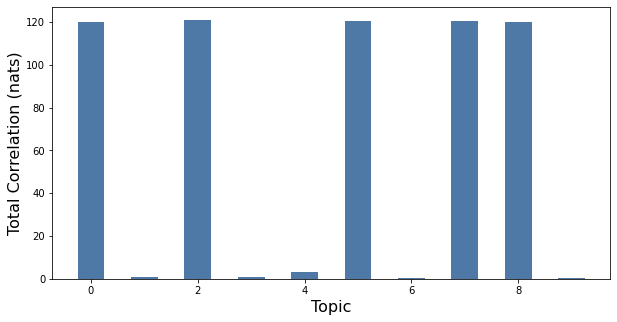

In [166]:
plt.figure(figsize=(10,5))
plt.bar(range(anchored_topic_model.tcs.shape[0]), anchored_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

We see the first topic is much more informative than the other topics. Given that we suspect that this topic is picking up on image encodings (as given by "dsl" and "n3jxp" in the topic) and other boilerplate text (as given by the high TC and lack of coherence of the rest of the topic), we could consider doing additional investigation and preprocessing to help ensure that the CorEx topic model does not pick up on these patterns which are not insightful.

### Pointwise Document TC

We can decompose total correlation further. The topic correlation is the average of the pointwise total correlations for each individual document. The pointwise total correlations can be accessed through **`log_z`**.

In [96]:
anchored_topic_model.log_z # n_docs x k_topics

array([[ 6.97805366e-01,  7.30858467e-01,  3.19642219e+01, ...,
        -4.96947761e-01, -1.62487070e+00,  2.83114359e+00],
       [ 6.97805639e-01,  7.51298247e-01,  5.75697805e-01, ...,
         1.13308045e+00,  2.41296682e-01,  2.00215085e+00],
       [ 6.97771128e-01, -4.50787426e-01,  5.75771076e-01, ...,
         1.04121711e+00, -1.42617441e-01,  2.50422078e+00],
       ...,
       [ 6.97837807e-01,  7.65160183e-01,  5.75778938e-01, ...,
         2.04507846e+00,  1.68985908e+00,  2.02939312e+00],
       [ 6.97617534e-01,  7.35555687e-01, -2.37247773e-02, ...,
         2.04507848e+00,  2.43242522e-01,  4.68797760e-01],
       [-2.00264937e+00,  7.45029888e-01,  5.75673168e-01, ...,
         2.04507953e+00, -5.31892864e-01, -1.49987539e+00]])

In [97]:
print(np.mean(anchored_topic_model.log_z, axis=0))
print(anchored_topic_model.tcs)

[1.21669545 0.64565789 1.06046758 1.15372106 1.97619983 1.25674327
 0.77631735 2.38443363 1.92971365 1.55438846]
[1.21669545 0.64565789 1.06046758 1.15372106 1.97619983 1.25674327
 0.77631735 2.38443363 1.92971365 1.55438846]


The pointwise total correlations in **`log_z`** represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics (see references below).

# get top training documents for each topic

In [52]:
#function to get topic of document:
def df_topic_of_doc(documents):
    l=[]
    for i,topics in enumerate(anchored_topic_model.labels):
        try:
            if True not in topics:
                l.append([documents[i],np.nan])
            else:
                num=np.where(topics == True)[0][0] 

                topics = anchored_topic_model.get_topics(topic=num)

                topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topics]
                # Unpack the info about the topic
                words,mis,signs = zip(*topic)    
                # convert to list
                word_ls=list(words)
                if num<len(anchor_words):
                    category=anchors[num]
                else:
                    category=np.nan
                    
                l.append([documents[i],num,category,word_ls])
        except Exception as e:
            print(e)
            print(i)
            print(documents[i])
            print(topics)
    return pd.DataFrame(l,columns=['document','topic_num','category','words'])

In [53]:
df_test=df_topic_of_doc(documents)

In [55]:
#this df shows what training document is assigned to which topic
df_test.to_excel('corex_topic_2/topics_with_top_docs.xlsx')

In [ ]:
#test topic modelling on new data

In [ ]:
test=pd.read_csv

# predict

In [ ]:
#what is 636, is it the total number of words?
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]
processed_docs = [tokenize(doc) for doc in test_doc]
word_count_dict = Dictionary(processed_docs)
#word_count_dict.filter_extremes(no_below=10, no_above=0.2) # word must appear >10 times, and appear in no more than 20% documents (in order to be selected as a word in the dictionary)
#bag_of_words_corpus = [word_count_dict.doc2bow(pdoc) for pdoc in processed_docs] # bow all document of corpus

In [169]:
predict_labels=anchored_topic_model.transform(test_matrix,details=True)
predict_labels

(array([[9.99999000e-01, 1.44115167e-03, 9.99999000e-01, ...,
         4.85528321e-06, 6.14013755e-06, 4.74454602e-04],
        [9.99999000e-01, 1.77081190e-03, 9.99999000e-01, ...,
         4.85496092e-06, 6.14274673e-06, 4.78300157e-04],
        [9.99999000e-01, 1.32818721e-03, 9.99999000e-01, ...,
         4.85496092e-06, 6.14274739e-06, 9.98559120e-01],
        ...,
        [9.99999000e-01, 9.99999000e-01, 9.98026642e-01, ...,
         1.00000000e-06, 9.65160082e-01, 4.78285796e-04],
        [9.99999000e-01, 9.99999000e-01, 9.99999000e-01, ...,
         1.00000000e-06, 9.65160082e-01, 4.78285796e-04],
        [9.99999000e-01, 9.99999000e-01, 9.99999000e-01, ...,
         9.99999000e-01, 9.99999000e-01, 9.99999000e-01]]),
 array([[-3.49525985e+00,  1.04436775e-01, -2.13520757e+00, ...,
          1.20563178e+00,  1.68987697e+00,  2.03073454e+00],
        [-3.48547132e+00,  9.76084958e-02, -4.52988202e+00, ...,
          1.20565342e+00,  1.68986134e+00,  2.02939695e+00],
        [-3.4

In [182]:
predict_labels[0].shape

(437, 10)

CorEx is a *discriminative* model, whereas LDA is a *generative* model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through **`log_p_y_given_x`** or **`p_y_given_x`**.

In [183]:
anchored_topic_model.p_y_given_x # n_docs x k_topics

array([[2.98216747e-05, 8.94993572e-04, 9.99999000e-01, ...,
        1.00000000e-06, 1.13039362e-02, 1.98385681e-06],
       [2.98229427e-05, 8.32756107e-04, 4.85603780e-05, ...,
        5.37469730e-06, 1.25528284e-04, 5.04643655e-04],
       [2.98277169e-05, 1.24057387e-02, 4.85421411e-05, ...,
        1.37924205e-05, 9.99999000e-01, 1.00000000e-06],
       ...,
       [2.98184342e-05, 7.83009676e-04, 4.85400980e-05, ...,
        1.00000000e-06, 6.14290673e-06, 4.78306498e-04],
       [2.98584035e-05, 8.45799379e-04, 4.94459764e-04, ...,
        1.00000000e-06, 2.98384738e-04, 5.90160326e-03],
       [3.41327212e-01, 8.46038079e-04, 4.85776260e-05, ...,
        1.00000000e-06, 1.09878238e-03, 9.70672827e-01]])

In [184]:
anchored_topic_model.p_y_given_x.shape

(8677, 10)

We can decompose total correlation further. The topic correlation is the average of the pointwise total correlations for each individual document. The pointwise total correlations can be accessed through log_z.

In [185]:

anchored_topic_model.log_z

array([[ 6.97805366e-01,  7.30858467e-01,  3.19642219e+01, ...,
        -4.96947761e-01, -1.62487070e+00,  2.83114359e+00],
       [ 6.97805639e-01,  7.51298247e-01,  5.75697805e-01, ...,
         1.13308045e+00,  2.41296682e-01,  2.00215085e+00],
       [ 6.97771128e-01, -4.50787426e-01,  5.75771076e-01, ...,
         1.04121711e+00, -1.42617441e-01,  2.50422078e+00],
       ...,
       [ 6.97837807e-01,  7.65160183e-01,  5.75778938e-01, ...,
         2.04507846e+00,  1.68985908e+00,  2.02939312e+00],
       [ 6.97617534e-01,  7.35555687e-01, -2.37247773e-02, ...,
         2.04507848e+00,  2.43242522e-01,  4.68797760e-01],
       [-2.00264937e+00,  7.45029888e-01,  5.75673168e-01, ...,
         2.04507953e+00, -5.31892864e-01, -1.49987539e+00]])

In [103]:
predict_labels=predict_labels[:436] #document * topic

In [105]:
predict_labels

array([[ True, False,  True, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       [ True, False,  True, ..., False, False,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ..., False,  True, False],
       [ True,  True,  True, ..., False,  True, False]])

In [138]:
#function to get topic of document:
def df_topic_of_doc(documents,labels):
    l=[]
    for i,topics in enumerate(labels):
        try:
            if True not in topics:
                l.append([documents[i],np.nan])
            else:
                
                arr=np.where(predict_labels[i] == True)
                l.append([documents[i],arr,'',''])
                for num in arr[0]:

                    topics = anchored_topic_model.get_topics(topic=num)

                    topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topics]
                    # Unpack the info about the topic
                    words,mis,signs = zip(*topic)    
                    # convert to list
                    word_ls=list(words)
                    if num<len(anchor_words):
                        category=anchors[num]
                    else:
                        category=np.nan
                    l.append([documents[i],num,category,word_ls])
        except Exception as e:
            print(e)
            print(i)
            print(documents[i])
            print(topics)
    return pd.DataFrame(l,columns=['document','topic_num','category','words'])

In [139]:
df_predict=df_topic_of_doc(test,predict_labels)

In [140]:
df_predict

,document,topic_num,category,words
0,"Agriculture, Forestry, and Animal Husbandry Da...","([0, 2, 5, 6],)",,
1,"Agriculture, Forestry, and Animal Husbandry Da...",0,"Agriculture, Forestry, and Animal Husbandry","[animal, agriculture, water, husbandry, forest..."
2,"Agriculture, Forestry, and Animal Husbandry Da...",2,Domestic and Personal Service,"[domestic, professional, occupation, gainful, ..."
3,"Agriculture, Forestry, and Animal Husbandry Da...",5,Professional Service,"[furniture, style, professional, design, chair..."
4,"Agriculture, Forestry, and Animal Husbandry Da...",6,"Public Service, Not Elsewhere Classified","[public, power, electric, generate, current, e..."
...,...,...,...,...
2114,skip main content search upload sign log book ...,5,Professional Service,"[furniture, style, professional, design, chair..."
2115,skip main content search upload sign log book ...,6,"Public Service, Not Elsewhere Classified","[public, power, electric, generate, current, e..."
2116,skip main content search upload sign log book ...,7,Trade,"[trade, worker, local, union, member, shop, or..."
2117,skip main content search upload sign log book ...,8,Transportation,"[piece, wood, inch, cut, surface, fig, glue, d..."


In [51]:
df_predict[df_predict['topic_num']==3]

,document,topic_num,category,words
371,Professional Service Technical engineers Train...,3.0,Extraction of Minerals,"[trade, union, local, international, workers, ..."
403,Domestic and Personal Service Midwives and nur...,3.0,Extraction of Minerals,"[trade, union, local, international, workers, ..."
404,Domestic and Personal Service Midwives and nur...,3.0,Extraction of Minerals,"[trade, union, local, international, workers, ..."


In [142]:
df_predict.to_excel('corex_topic_3/predicted_1910_pre_processed.xlsx')

### Document Labels

As with the topic words, the most probable documents per topic can also be easily accessed. Documents are sorted according to log probabilities which is why the highest probability documents have a score of 0 ($e^0 = 1$) and other documents have negative scores (for example, $e^{-0.5} \approx 0.6$).

In [147]:
# Print a single topic from CorEx topic model
doc_ls=anchored_topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


somehow riding sick sister to charity is categorized as agriculture, really doens't work

In [ ]:
for doc_num in topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob'):
    print(documents[doc_num[0]])

CorEx is a *discriminative* model, whereas LDA is a *generative* model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through **`log_p_y_given_x`** or **`p_y_given_x`**.

In [ ]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

We can also use a softmax to make a binary determination of which documents belong to each topic. These softmax labels can be accessed through **`labels`**.

In [155]:
topic_model.labels

array([[False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]])

In [ ]:
len(topic_model.labels[0])

Since CorEx does not prescribe a probability distribution of topics over each document, this means that a document could possibly belong to no topics (all 0's across topics in **`labels`**) or all topics (all 1's across topics in **`labels`**).

Note, in the above topic model, topics will no longer be sorted according to descending TC. Instead, the first topic will be the one with "nasa" and "space" anchored to it, the second topic will be the one with "sports" and "stadium" anchored to it, and so on.  

Observe, the topic with "love" and "hope" anchored to it is less interpretable than the other three topics. This could be a sign that there is not a good topic around these two words, and one should consider if it is appropriate to anchor around them.

We can continue to develop even more involved anchoring strategies. Here we anchor "nasa" by itself, as well as in two other topics each with "politics" and "news" to find different aspects around the word "nasa". We also create a fourth anchoring of "war" to a topic.

### Choosing Anchor Strength

The anchor strength controls how much weight CorEx puts towards maximizing the mutual information between the anchor words and their respective topics. Anchor strength should always be set at a value *greater than* 1, since setting anchor strength between 0 and 1 only recovers the unsupervised CorEx objective. Empirically, setting anchor strength from 1.5-3 seems to nudge the topic model towards the anchor words. Setting anchor strength greater than 5 is strongly enforcing that the CorEx topic model find a topic associated with the anchor words.

We encourage users to experiment with the anchor strength and determine what values are best for their needs.

## Other Output

The **`vis_topic`** module provides support for outputting topics and visualizations of the CorEx topic model. The code below creates a results direcory named "twenty" in your working directory.

In [ ]:
vt.vis_rep(topic_model, column_label=words, prefix='twenty')

## Further Reading

Our TACL paper details the theory of the CorEx topic model, its sparsity optimization, anchoring via the information bottleneck, comparisons to LDA, and anchoring experiments. The two papers from Greg Ver Steeg and Aram Galstyan develop the CorEx theory in general and provide further motivation and details of the underlying CorEx mechanisms. Hodas et al. demonstrated early CorEx topic model results and investigated an application of pointwise total correlations to quantify "surprising" documents.

1. [Anchored Correlation Explanation: Topic Modeling with Minimal Domain Knowledge](https://www.transacl.org/ojs/index.php/tacl/article/view/1244), Gallagher et al., TACL 2017.

2. [Discovering Structure in High-Dimensional Data Through Correlation Explanation](https://arxiv.org/abs/1406.1222), Ver Steeg and Galstyan, NIPS 2014. 

3. [Maximally Informative Hierarchical Representions of High-Dimensional Data](https://arxiv.org/abs/1410.7404), Ver Steeg and Galstyan, AISTATS 2015.

4. [Disentangling the Lexicons of Disaster Response in Twitter](https://dl.acm.org/citation.cfm?id=2741728), Hodas et al., WWW 2015.